<div class="alert alert-block alert-success">
<h3><center style="line-height: 1">MSDS-422: Practical Machine Learning</center></h3>
<h1><center style="line-height: 1">Final Project: Group 5</center></h1>
<h2><center style="line-height: 1">Identifying Malware in Network Traffic with Supervised Learning</center></h2>

<b>Group 5</b>:
<ul>
    <li>Aishwarya Mathuria</li>
    <li>Akshaya Venkat Raman</li>
    <li>Tanmay Swami</li>
    <li>Yatika Taneja</li>
</ul>
</div>

In [264]:
# Import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pathlib import Path
import glob
from datetime import datetime
import ipaddress
from collections import Counter
from scipy import stats
import os
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.preprocessing import LabelEncoder
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
warnings.filterwarnings('ignore')

<div style="background: #fcf9be; border: 1px solid #f0e61f; padding: 10px 20px">
    <h1>Load Dataset</h1>
</div>

In [280]:
# Load all CSV files without any cleaning
print("Loading raw data")
csv_files = glob.glob('data/*.csv')
print(f"Found {len(csv_files)} CSV files:")
for file in sorted(csv_files):
    size_mb = Path(file).stat().st_size / (1024 * 1024)
    print(f"  - {file}: {size_mb:.2f} MB")

all_dataframes = []

for file in csv_files:
    try:
        print(f"Loading {file}...")
        df = pd.read_csv(file, sep='|')
        all_dataframes.append(df)
        print(f"  - Loaded {len(df)} records")
    except Exception as e:
        print(f"Error loading {file}: {e}")

if not all_dataframes:
    raise ValueError("No data files could be loaded")

df = pd.concat(all_dataframes, ignore_index=True)
print(f"\nCombined raw dataset shape: {df.shape}")

df['label'] = df.apply(
    lambda row: f"{row['label']} {row['detailed-label']}" if ((row['label'] != 'Benign') and row['detailed-label'] != 'nan') else 'Benign',
    axis=1
)

# Drop detailed-label column
if 'detailed-label' in df.columns:
    df.drop(columns=['detailed-label'], inplace=True)

print("\nUpdated label distribution:")
print(df['label'].value_counts())

numeric_cols = ['duration', 'orig_bytes', 'resp_bytes', 'orig_pkts', 'resp_pkts', 'orig_ip_bytes', 'resp_ip_bytes']
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

Loading raw data
Found 6 CSV files:
  - data/CTU-IoT-Malware-Capture-3-1conn.log.labeled.csv: 22.09 MB
  - data/CTU-IoT-Malware-Capture-42-1conn.log.labeled.csv: 0.54 MB
  - data/CTU-IoT-Malware-Capture-44-1conn.log.labeled.csv: 0.03 MB
  - data/CTU-IoT-Malware-Capture-48-1conn.log.labeled.csv: 498.91 MB
  - data/CTU-IoT-Malware-Capture-60-1conn.log.labeled.csv: 442.23 MB
  - data/CTU-IoT-Malware-Capture-8-1conn.log.labeled.csv: 1.27 MB
Loading data/CTU-IoT-Malware-Capture-3-1conn.log.labeled.csv...
  - Loaded 156103 records
Loading data/CTU-IoT-Malware-Capture-60-1conn.log.labeled.csv...
  - Loaded 3581028 records
Loading data/CTU-IoT-Malware-Capture-44-1conn.log.labeled.csv...
  - Loaded 237 records
Loading data/CTU-IoT-Malware-Capture-8-1conn.log.labeled.csv...
  - Loaded 10403 records
Loading data/CTU-IoT-Malware-Capture-48-1conn.log.labeled.csv...
  - Loaded 3394338 records
Loading data/CTU-IoT-Malware-Capture-42-1conn.log.labeled.csv...
  - Loaded 4426 records

Combined raw datas

<div style="background: #fcf9be; border: 1px solid #f0e61f; padding: 10px 20px">
    <h1>Exploratory Data Analysis</h1>
</div>

<div style="background: #c6eed6; border: 1px solid #6ad194; padding: 10px 20px">
    <h3>Basic dataset Information</h3>
</div>

In [271]:
print("\n")
print(f"Total records: {len(df)}")
print(f"Total columns: {len(df.columns)}")
print(f"Shape: {df.shape}")
df.info(memory_usage='deep')
print("\n")



Total records: 7146535
Total columns: 23
Shape: (7146535, 23)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7146535 entries, 0 to 7146534
Data columns (total 23 columns):
 #   Column          Dtype  
---  ------          -----  
 0   ts              float64
 1   uid             object 
 2   id.orig_h       object 
 3   id.orig_p       float64
 4   id.resp_h       object 
 5   id.resp_p       float64
 6   proto           object 
 7   service         object 
 8   duration        object 
 9   orig_bytes      object 
 10  resp_bytes      object 
 11  conn_state      object 
 12  local_orig      object 
 13  local_resp      object 
 14  missed_bytes    float64
 15  history         object 
 16  orig_pkts       float64
 17  orig_ip_bytes   float64
 18  resp_pkts       float64
 19  resp_ip_bytes   float64
 20  tunnel_parents  object 
 21  label           object 
 22  detailed-label  object 
dtypes: float64(8), object(15)
memory usage: 5.6 GB




In [282]:
print(df.shape)
for col in df.columns:
    print(f"{col}: {df[col].nunique()} unique values")

(7146535, 22)
ts: 7146535 unique values
uid: 7146535 unique values
id.orig_h: 3101 unique values
id.orig_p: 65497 unique values
id.resp_h: 1749646 unique values
id.resp_p: 209 unique values
proto: 3 unique values
service: 7 unique values
duration: 62030 unique values
orig_bytes: 153 unique values
resp_bytes: 248 unique values
conn_state: 13 unique values
local_orig: 1 unique values
local_resp: 1 unique values
missed_bytes: 13 unique values
history: 123 unique values
orig_pkts: 117 unique values
orig_ip_bytes: 475 unique values
resp_pkts: 74 unique values
resp_ip_bytes: 682 unique values
tunnel_parents: 1 unique values
label: 12 unique values


In [272]:
df.head()

,ts,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,proto,service,duration,orig_bytes,...,local_resp,missed_bytes,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,tunnel_parents,label,detailed-label
0,1.526756e+09,C9YvmJ3zxtuqxWxLW5,192.168.2.5,38792.0,200.168.87.203,59353.0,tcp,-,2.998333,0,...,-,0.0,S,3.0,180.0,0.0,0.0,-,Malicious,PartOfAHorizontalPortScan
1,1.526756e+09,CGsZqZ3UiQexLzPRVb,192.168.2.5,38792.0,200.168.87.203,59353.0,tcp,-,-,-,...,-,0.0,S,1.0,60.0,0.0,0.0,-,Malicious,PartOfAHorizontalPortScan
2,1.526756e+09,C0LkBW2VEa292Nvet8,192.168.2.5,38793.0,200.168.87.203,59353.0,tcp,-,2.997182,0,...,-,0.0,S,3.0,180.0,0.0,0.0,-,Malicious,PartOfAHorizontalPortScan
3,1.526756e+09,CMDLrn2cVhrqvW8gKa,192.168.2.5,38793.0,200.168.87.203,59353.0,tcp,-,-,-,...,-,0.0,S,1.0,60.0,0.0,0.0,-,Malicious,PartOfAHorizontalPortScan
4,1.526756e+09,C2UM8f4knuL5Vnvp3h,192.168.2.5,38794.0,200.168.87.203,59353.0,tcp,-,2.996286,0,...,-,0.0,S,3.0,180.0,0.0,0.0,-,Malicious,PartOfAHorizontalPortScan


<div style="background: #c6eed6; border: 1px solid #6ad194; padding: 10px 20px">
    <h3>Columns</h3>
</div>

In [252]:
print("Columns:")
for i, col in enumerate(df.columns, 1):
    print(f"   {i:2d}. {col}")

Columns:
    1. ts
    2. uid
    3. id.orig_h
    4. id.orig_p
    5. id.resp_h
    6. id.resp_p
    7. proto
    8. service
    9. duration
   10. orig_bytes
   11. resp_bytes
   12. conn_state
   13. local_orig
   14. local_resp
   15. missed_bytes
   16. history
   17. orig_pkts
   18. orig_ip_bytes
   19. resp_pkts
   20. resp_ip_bytes
   21. tunnel_parents
   22. label


<div style="background: #c6eed6; border: 1px solid #6ad194; padding: 10px 20px">
    <h3>Data types</h3>
</div>

In [255]:
print(df.dtypes.value_counts())

float64    11
object     11
Name: count, dtype: int64


<div style="background: #c6eed6; border: 1px solid #6ad194; padding: 10px 20px">
    <h3>Missing values</h3>
</div>

,MissingValues,Percent
duration,80129,48.12
orig_bytes,80129,48.12
resp_bytes,80129,48.12


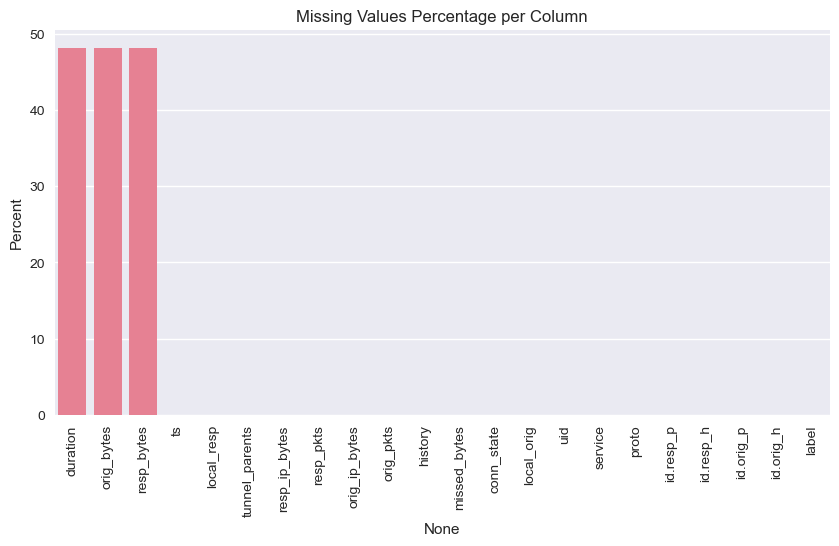

In [258]:
# Missing values summary
missing = df.isnull().sum().sort_values(ascending=False)
missing_percent = (missing / len(df) * 100).round(2)

missing_df = pd.DataFrame({'MissingValues': missing, 'Percent': missing_percent})
display(missing_df[missing_df.MissingValues > 0])

# Visualize missing values
plt.figure(figsize=(10,5))
sns.barplot(x=missing_df.index, y=missing_df['Percent'])
plt.xticks(rotation=90)
plt.title("Missing Values Percentage per Column")
plt.show()

<div style="background: #c6eed6; border: 1px solid #6ad194; padding: 10px 20px">
    <h3>Target value Distribution</h3>
</div>

label
Malicious PartOfAHorizontalPortScan    145597
Malicious C&C                            8230
Benign                                   6717
Malicious Attack                         5962
Name: count, dtype: int64


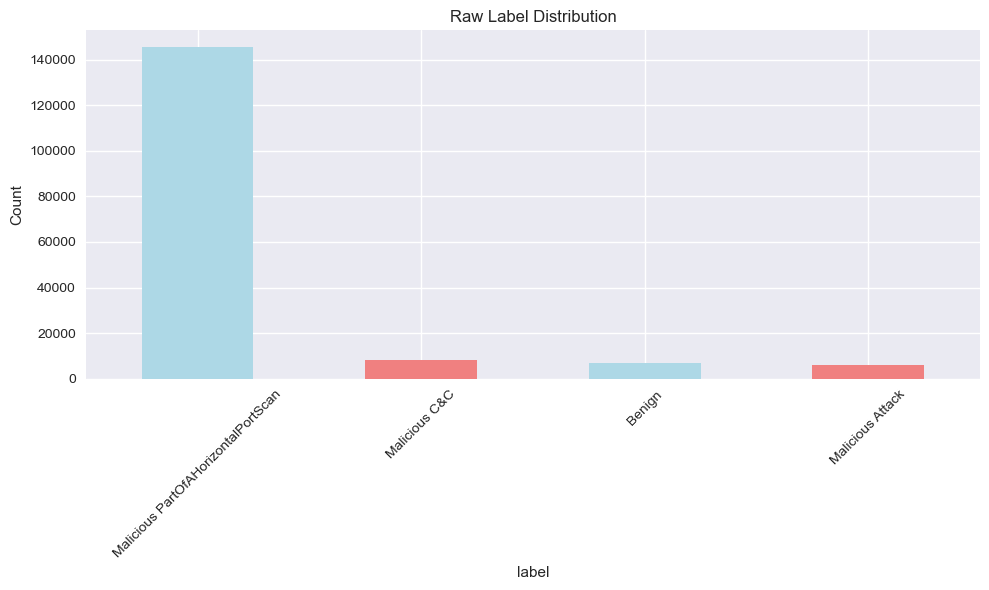

In [261]:
label_counts = df['label'].value_counts()
print(label_counts)

plt.figure(figsize=(10, 6))
label_counts.plot(kind='bar', color=['lightblue', 'lightcoral'])
plt.title('Raw Label Distribution')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<div style="background: #c6eed6; border: 1px solid #6ad194; padding: 10px 20px">
    <h3>Histograms for numerical features</h3>
</div>

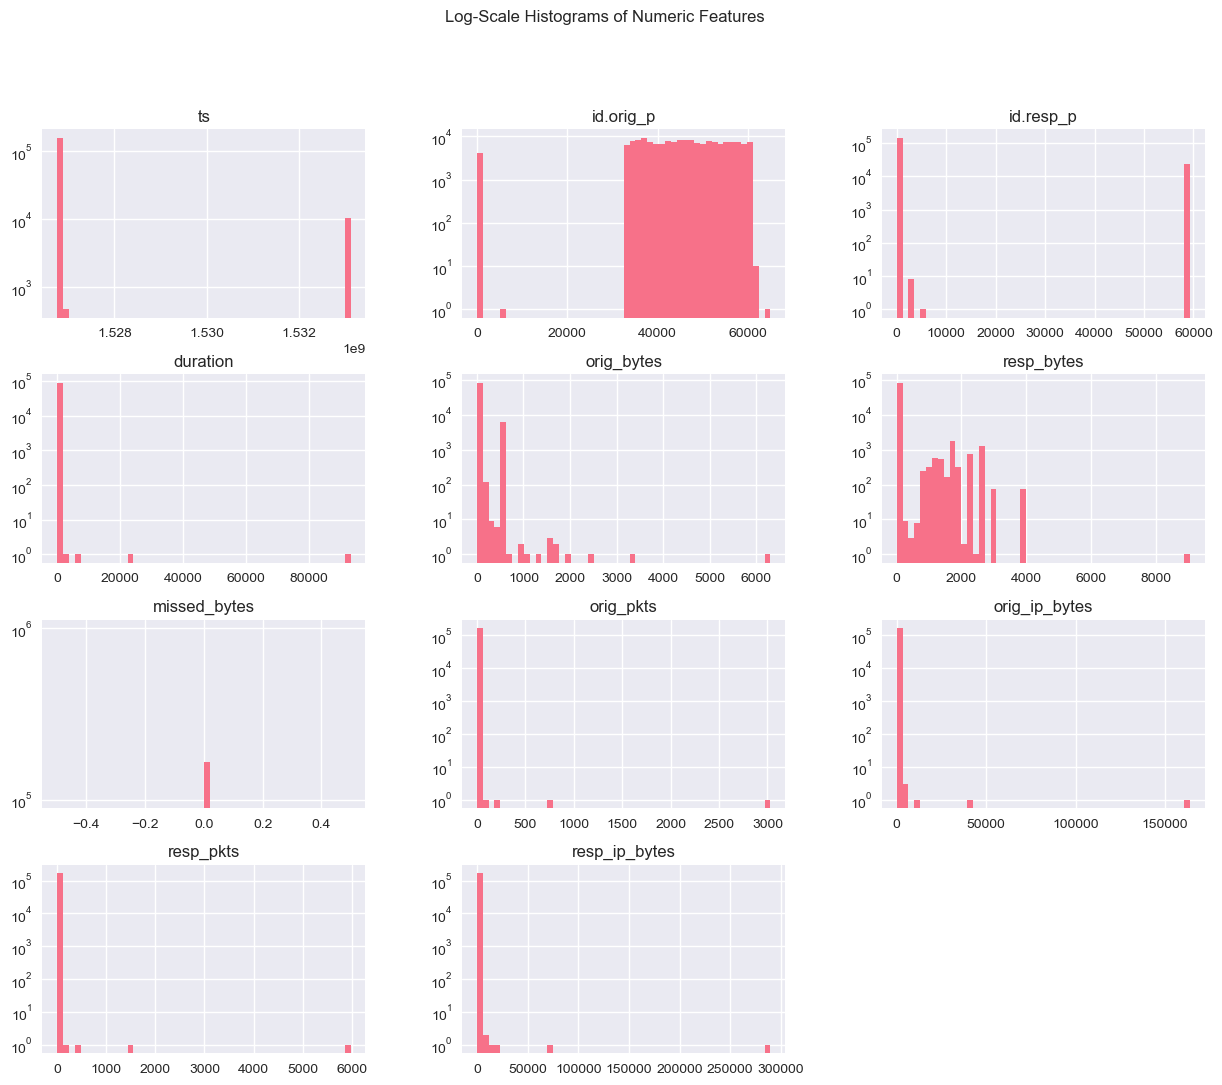

In [190]:
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
df[numeric_cols].hist(figsize=(15, 12), bins=50, log=True)
plt.suptitle("Log-Scale Histograms of Numeric Features")
plt.show()

<div style="background: #c6eed6; border: 1px solid #6ad194; padding: 10px 20px">
    <h3>Correlation Heatmap</h3>
</div>

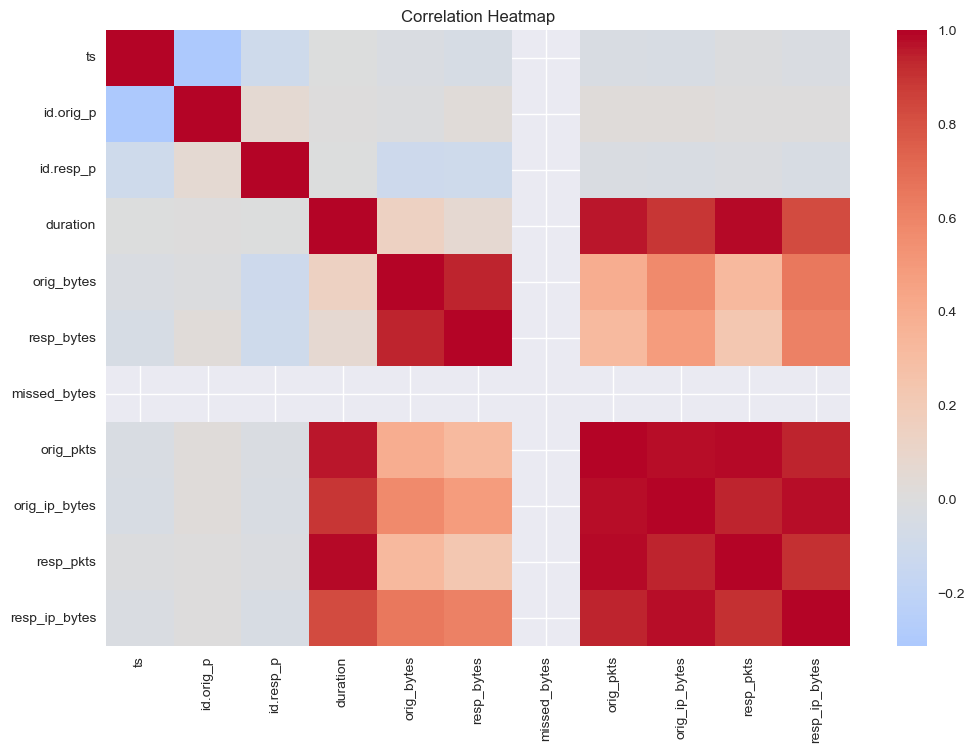

In [192]:
plt.figure(figsize=(12,8))
corr = df[numeric_cols].corr()
sns.heatmap(corr, cmap='coolwarm', center=0)
plt.title("Correlation Heatmap")
plt.show()

<div style="background: #c6eed6; border: 1px solid #6ad194; padding: 10px 20px">
    <h3>Boxplots by Label</h3>
</div>

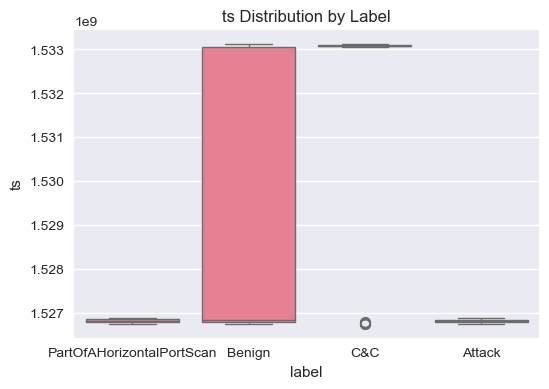

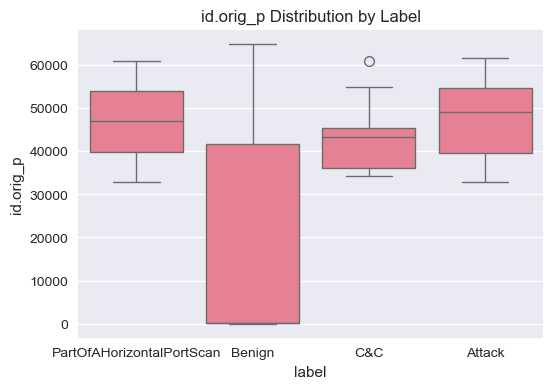

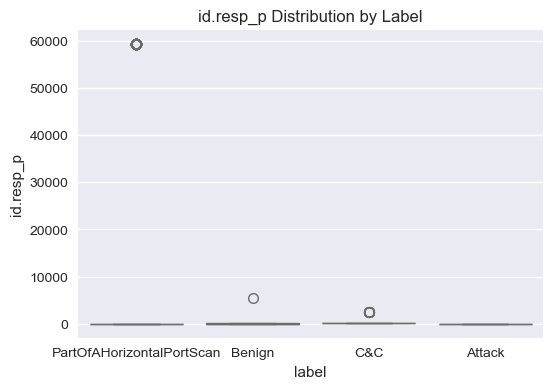

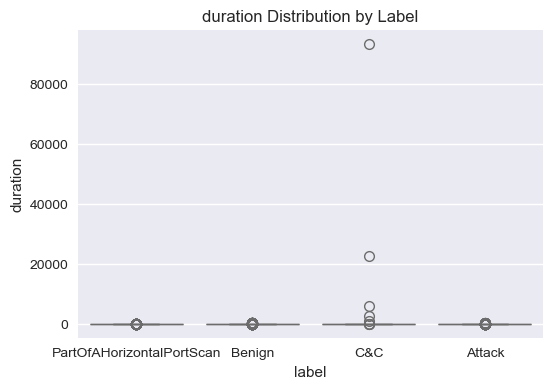

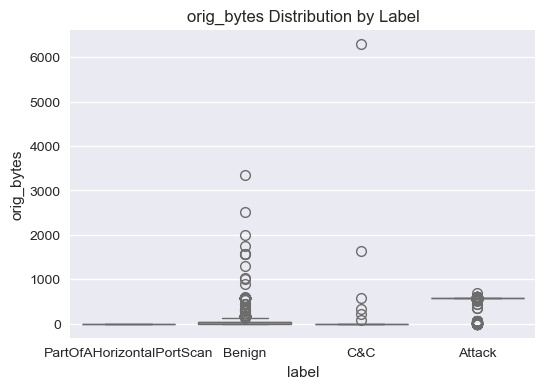

In [194]:
for col in numeric_cols[:5]:  # first 5 numeric features
    plt.figure(figsize=(6,4))
    sns.boxplot(x='label', y=col, data=df)
    plt.title(f"{col} Distribution by Label")
    plt.show()

<div style="background: #c6eed6; border: 1px solid #6ad194; padding: 10px 20px">
    <h3>Outlier detection</h3>
</div>

In [196]:
plt.figure(figsize=(16, 8))
sns.boxplot(data=df[numeric_cols], orient='h', palette='Set2')
plt.title("Boxplots of Numeric Features (Horizontal View)")
plt.xlabel("Value")
plt.show()

for col in numeric_cols:
    q1, q3 = np.percentile(df[col].dropna(), [25, 75])
    iqr = q3 - q1
    lower, upper = q1 - 1.5*iqr, q3 + 1.5*iqr
    outlier_count = ((df[col] < lower) | (df[col] > upper)).sum()
    print(f"{col}: {outlier_count} outliers")

ts: 10403 outliers
id.orig_p: 4124 outliers
id.resp_p: 35649 outliers
duration: 13975 outliers
orig_bytes: 9217 outliers
resp_bytes: 8976 outliers
missed_bytes: 0 outliers
orig_pkts: 6081 outliers
orig_ip_bytes: 6082 outliers
resp_pkts: 11442 outliers
resp_ip_bytes: 11442 outliers


<div style="background: #fcf9be; border: 1px solid #f0e61f; padding: 10px 20px">
    <h1>Data Cleaning and Preparation</h1>
</div>

<div style="background: #c6eed6; border: 1px solid #6ad194; padding: 10px 20px">
    <h3>Handling missing values</h3>
</div>

In [199]:
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

In [200]:
for col in numeric_cols:
    if col in df.columns:
        print(f"Converting {col} to numeric...")
        df[col] = pd.to_numeric(df[col], errors='coerce')
        missing_before = df[col].isnull().sum()
        df[col] = df[col].fillna(0)
        missing_after = df[col].isnull().sum()
        print(f"    Missing values: {missing_before} -> {missing_after}")

Converting ts to numeric...
    Missing values: 0 -> 0
Converting id.orig_p to numeric...
    Missing values: 0 -> 0
Converting id.resp_p to numeric...
    Missing values: 0 -> 0
Converting duration to numeric...
    Missing values: 80129 -> 0
Converting orig_bytes to numeric...
    Missing values: 80129 -> 0
Converting resp_bytes to numeric...
    Missing values: 80129 -> 0
Converting missed_bytes to numeric...
    Missing values: 0 -> 0
Converting orig_pkts to numeric...
    Missing values: 0 -> 0
Converting orig_ip_bytes to numeric...
    Missing values: 0 -> 0
Converting resp_pkts to numeric...
    Missing values: 0 -> 0
Converting resp_ip_bytes to numeric...
    Missing values: 0 -> 0


<div style="background: #c6eed6; border: 1px solid #6ad194; padding: 10px 20px">
    <h3>Feature Engineering</h3>
</div>

In [202]:
if {'TotalBytes', 'TotalPackets', 'Duration'}.issubset(df.columns):
    df['BytesPerPacket'] = df['TotalBytes'] / (df['TotalPackets'] + 1)
    df['PacketsPerSecond'] = df['TotalPackets'] / (df['Duration'] + 1e-6)

# Encode Protocols
if 'Protocol' in df.columns:
    df = pd.get_dummies(df, columns=['Protocol'], drop_first=True)

# Convert IP addresses to numeric
import ipaddress
def ip_to_int(ip):
    try:
        return int(ipaddress.IPv4Address(ip))
    except:
        return None

for col in ['SourceIP','DestinationIP']:
    if col in df.columns:
        df[col+'_int'] = df[col].apply(ip_to_int)

<div style="background: #c6eed6; border: 1px solid #6ad194; padding: 10px 20px">
    <h3>Convert timestamp to datetime</h3>
</div>

In [204]:
print("Converting timestamps")
df['timestamp'] = pd.to_datetime(df['ts'], unit='s', errors='coerce')
invalid_timestamps = df['timestamp'].isnull().sum()
print(f"    Invalid timestamps: {invalid_timestamps}")

# Adding temporal features
df['hour'] = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.day_name()
print("Added hour and day_of_week features")

Converting timestamps
    Invalid timestamps: 0
Added hour and day_of_week features


<div style="background: #c6eed6; border: 1px solid #6ad194; padding: 10px 20px">
    <h3>Handling IP addresses and ports</h3>
</div>

In [206]:
print("Processing origin IP addresses...")
df['is_private_orig'] = df['id.orig_h'].apply(lambda x: 
    ipaddress.ip_address(x).is_private if pd.notna(x) else False)

print("Processing response IP addresses...")
df['is_private_resp'] = df['id.resp_h'].apply(lambda x: 
    ipaddress.ip_address(x).is_private if pd.notna(x) else False)

Processing origin IP addresses...
Processing response IP addresses...


In [207]:
# Categorize ports into common service types
def categorize_port(port):
    try:
        port = int(port)
        if port <= 1024:
            return 'well_known'
        elif port <= 49151:
            return 'registered'
        else:
            return 'dynamic'
    except:
        return 'unknown'

print("Categorizing origin ports...")
df['orig_port_category'] = df['id.orig_p'].apply(categorize_port)
    
print("Categorizing response ports...")
df['resp_port_category'] = df['id.resp_p'].apply(categorize_port)

Categorizing origin ports...
Categorizing response ports...


<div style="background: #c6eed6; border: 1px solid #6ad194; padding: 10px 20px">
    <h3>Handling duplicates</h3>
</div>

In [209]:
duplicates_before = df.duplicated().sum()
df = df.drop_duplicates()
duplicates_after = df.duplicated().sum()
print(f"Removed {duplicates_before - duplicates_after} duplicate rows")

Removed 0 duplicate rows


<div style="background: #c6eed6; border: 1px solid #6ad194; padding: 10px 20px">
    <h3>Class Imbalance Handling</h3>
</div>

In [211]:
nan_summary = df.isna().sum()
print(nan_summary[nan_summary > 0])
X = df[numeric_cols]
y = df['label']

sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)

print("\n\nShape before SMOTE:", df.shape)
print("\nClass distribution before SMOTE:", y.value_counts())
print("\n\nShape after SMOTE:", df.shape)
print("\nClass distribution after SMOTE:", y_res.value_counts())

df = pd.concat([pd.DataFrame(X_res, columns=X.columns), pd.Series(y_res, name='label')], axis=1)

Series([], dtype: int64)


Before SMOTE: label
PartOfAHorizontalPortScan    145597
C&C                            8230
Benign                         6717
Attack                         5962
Name: count, dtype: int64


After SMOTE: label
PartOfAHorizontalPortScan    145597
Benign                       145597
C&C                          145597
Attack                       145597
Name: count, dtype: int64


Shape after SMOTE: (582388, 12)
Class distribution after SMOTE:
 label
PartOfAHorizontalPortScan    145597
Benign                       145597
C&C                          145597
Attack                       145597
Name: count, dtype: int64


<div style="background: #c6eed6; border: 1px solid #6ad194; padding: 10px 20px">
    <h3>Label encoding categorical values</h3>
</div>

In [213]:
# Identify columns with only 1 unique value
single_value_cols = [col for col in df.columns if df[col].nunique() <= 1]

print("Dropping columns with a single unique value:", single_value_cols)

# Drop these columns
df = df.drop(columns=single_value_cols)

Dropping columns with a single unique value: ['missed_bytes']


In [214]:
encoders = {}
for col in df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    encoders[col] = le
    print(f"Encoded column '{col}' with {len(le.classes_)} classes")

Encoded column 'label' with 4 classes


<div style="background: #fcf9be; border: 1px solid #f0e61f; padding: 10px 20px">
    <h1>Post Cleanup Analysis and Processing</h1>
</div>

In [216]:
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

<div style="background: #c6eed6; border: 1px solid #6ad194; padding: 10px 20px">
    <h3>Missing Values</h3>
</div>

In [218]:
missing_after = df.isnull().sum()
print("Missing values after cleanup:")
print(missing_after[missing_after > 0])

Missing values after cleanup:
Series([], dtype: int64)


<div style="background: #c6eed6; border: 1px solid #6ad194; padding: 10px 20px">
    <h3>Negative values check</h3>
</div>

In [220]:
for col in numeric_cols:
    if col in df.columns:
        negative_count = (df[col] < 0).sum()
        if negative_count > 0:
            print(f"{col}: {negative_count} negative values")
        else:
            print(f"{col}: No negative values")

ts: No negative values
id.orig_p: No negative values
id.resp_p: No negative values
duration: No negative values
orig_bytes: No negative values
resp_bytes: No negative values
orig_pkts: No negative values
orig_ip_bytes: No negative values
resp_pkts: No negative values
resp_ip_bytes: No negative values
label: No negative values


<div style="background: #c6eed6; border: 1px solid #6ad194; padding: 10px 20px">
    <h3>Target value distribution</h3>
</div>

label
3    145597
1    145597
2    145597
0    145597
Name: count, dtype: int64


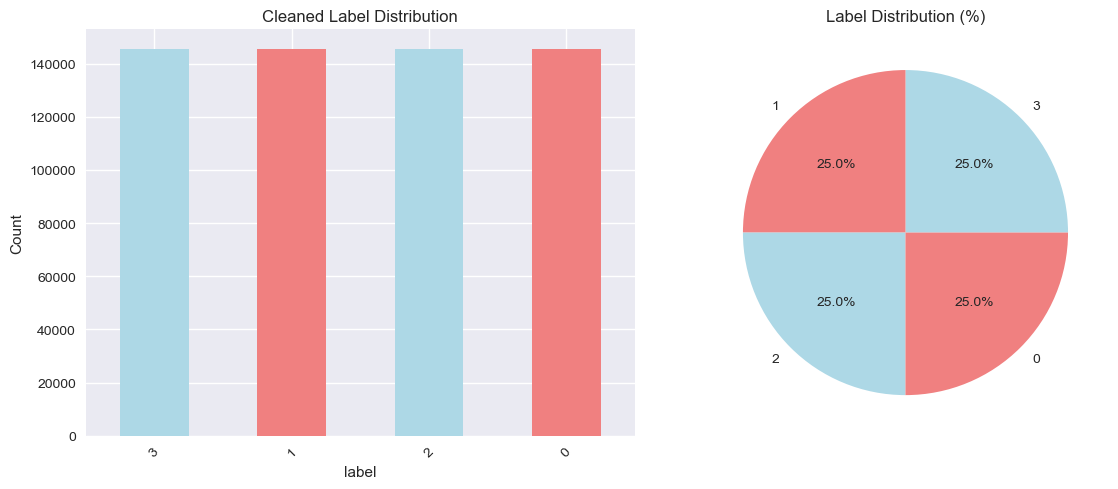

Class imbalance ratio: 1.00


In [222]:
label_counts = df['label'].value_counts()
print(label_counts)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
label_counts.plot(kind='bar', color=['lightblue', 'lightcoral'])
plt.title('Cleaned Label Distribution')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.subplot(1, 2, 2)
plt.pie(label_counts.values, labels=label_counts.index, autopct='%1.1f%%', 
        colors=['lightblue', 'lightcoral'])
plt.title('Label Distribution (%)')
plt.tight_layout()
plt.savefig('cleaned_label_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Class imbalance ratio: {label_counts[1] / label_counts[0]:.2f}")

<div style="background: #c6eed6; border: 1px solid #6ad194; padding: 10px 20px">
    <h3>Traffic statistics</h3>
</div>

Traffic Statistics Summary:
            duration     orig_bytes     resp_bytes      orig_pkts  \
count  582388.000000  582388.000000  582388.000000  582388.000000   
mean        4.297568     154.790989     480.673860       4.855292   
std       299.909351     254.120397     863.290970      11.288692   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       1.000000   
50%         0.330129       0.000000       0.000000       1.000000   
75%         2.997448     537.000000     888.062709      13.000000   
max     93280.030966    6303.000000    9069.000000    3031.000000   

           resp_pkts  
count  582388.000000  
mean        4.166211  
std        20.281615  
min         0.000000  
25%         0.000000  
50%         0.000000  
75%        11.000000  
max      5975.000000  


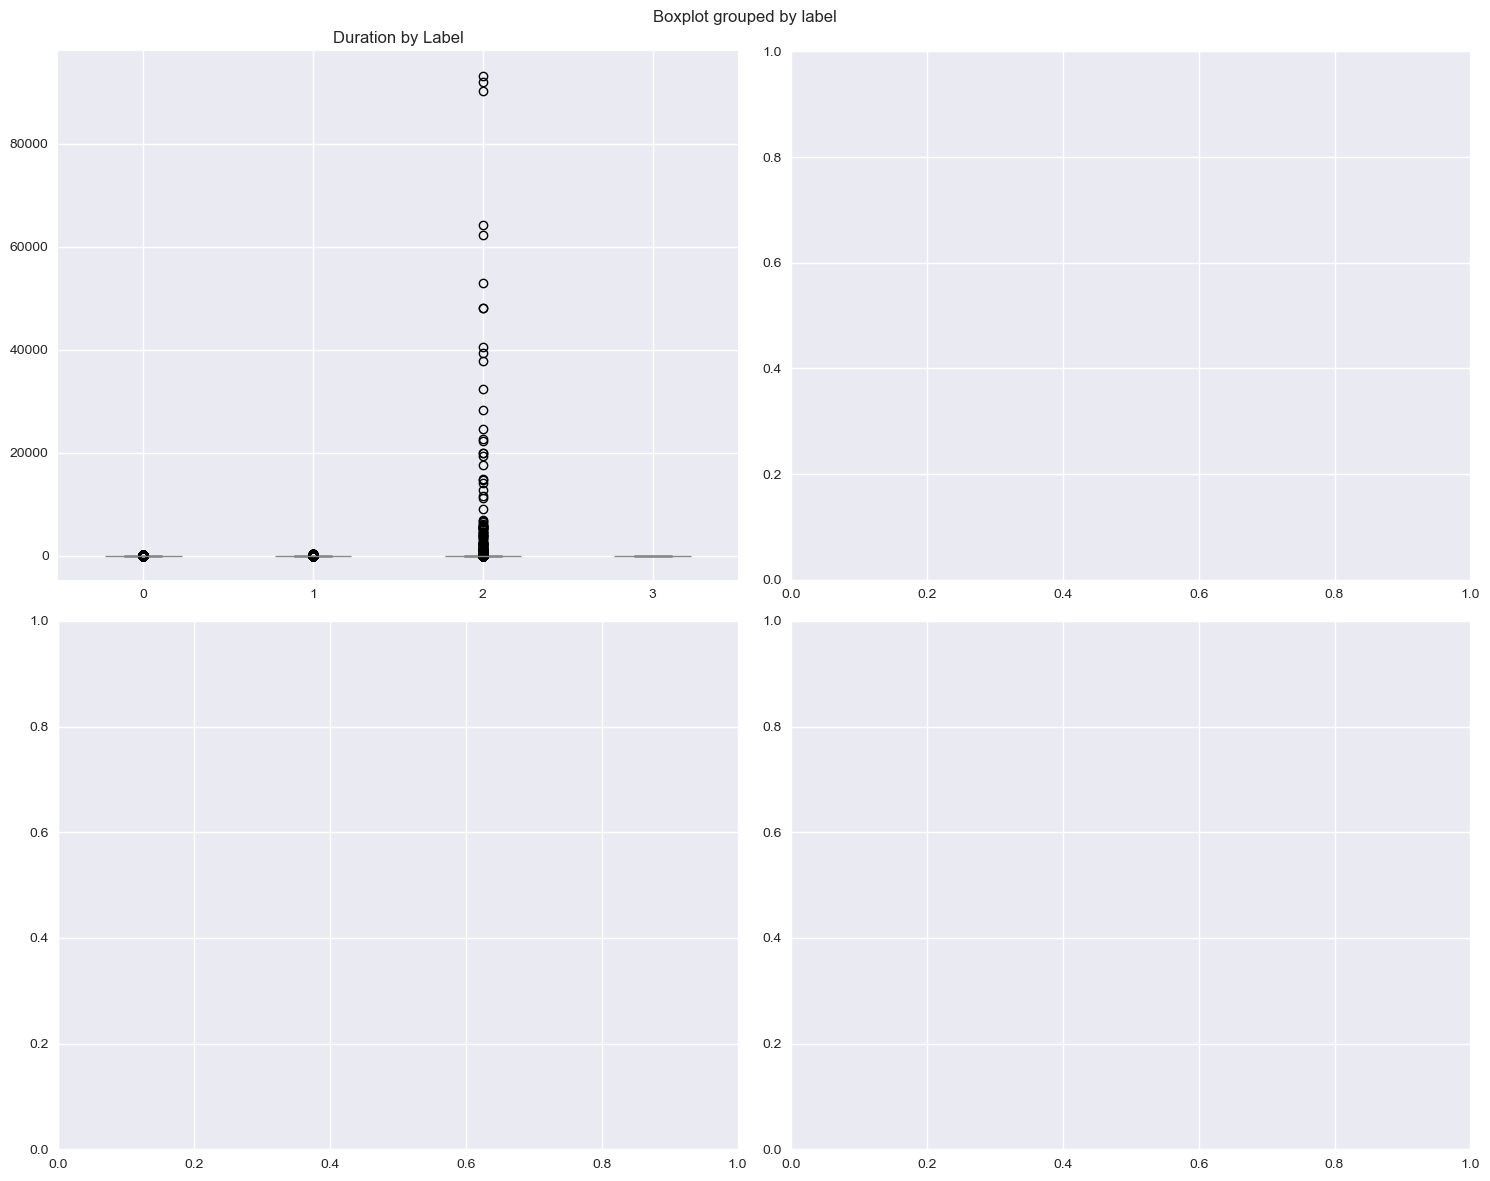

In [224]:
traffic_cols = ['duration', 'orig_bytes', 'resp_bytes', 'total_bytes', 'orig_pkts', 'resp_pkts', 'total_packets', 'bytes_per_packet']

available_traffic_cols = [col for col in traffic_cols if col in df.columns]
if available_traffic_cols:
    print("Traffic Statistics Summary:")
    print(df[available_traffic_cols].describe())
    
    # Plot traffic statistics by label
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Traffic Statistics by Label (Cleaned)', fontsize=16)
    
    for i, col in enumerate(['duration', 'total_bytes', 'total_packets', 'bytes_per_packet']):
        if col in df.columns:
            row, col_idx = i // 2, i % 2
            df.boxplot(column=col, by='label', ax=axes[row, col_idx])
            axes[row, col_idx].set_title(f'{col.title()} by Label')
            axes[row, col_idx].set_xlabel('')
    plt.tight_layout()
    plt.show()

<div style="background: #c6eed6; border: 1px solid #6ad194; padding: 10px 20px">
    <h3>Correlation analysis</h3>
</div>

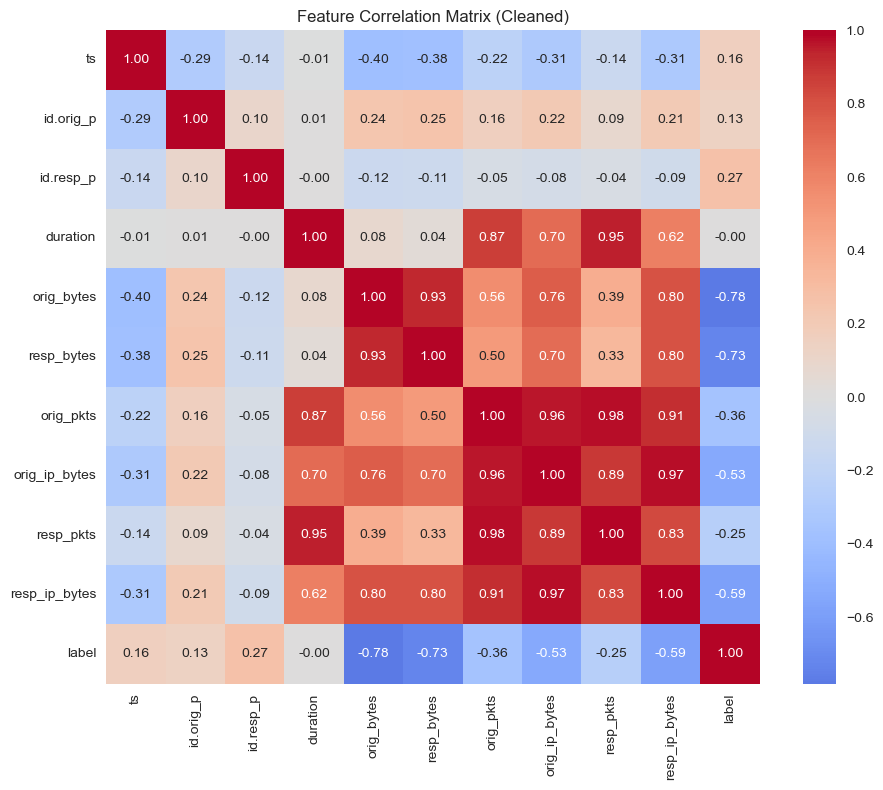

In [226]:
correlation_matrix = df[numeric_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, square=True, fmt='.2f')
plt.title('Feature Correlation Matrix (Cleaned)')
plt.tight_layout()
plt.show()

<div style="background: #c6eed6; border: 1px solid #6ad194; padding: 10px 20px">
    <h3>Scaling and Train-Test Split</h3>
</div>

In [228]:
X = df.drop(columns=['label'])
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y_res)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

<div style="background: #fcf9be; border: 1px solid #f0e61f; padding: 10px 20px">
    <h1>Cross Validation</h1>
    <ul>
        <li>XGBoost</li>
        <li>Random Forest</li>
        <li>LiteGBM</li>
        <li>Extra Trees</li>
        <li>Gradient Boost Trees</li>
    </ul>
</div>

In [239]:
# Define models
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Extra Trees": ExtraTreesClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='logloss'),
    "LightGBM": LGBMClassifier(n_estimators=100, force_col_wise=True, random_state=42)
}

# Cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results = []

for name, model in models.items():
    print(f"\nTraining {name} with PCA features...")
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='f1', n_jobs=-1)
    results.append({
        'Model': name,
        'Mean F1-Score': np.mean(scores),
        'Std Dev': np.std(scores)
    })

results_df = pd.DataFrame(results).sort_values(by='Mean F1-Score', ascending=False)
results_df


Training Random Forest with PCA features...

Training Extra Trees with PCA features...

Training Gradient Boosting with PCA features...

Training XGBoost with PCA features...


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [21:33:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [21:33:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [21:33:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [21:33:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i


Training LightGBM with PCA features...


,Model,Mean Accuracy,Std Dev
1,Extra Trees,0.998779,0.000074
0,Random Forest,0.998431,0.000072
3,XGBoost,0.997547,0.000149
4,LightGBM,0.997463,0.000067
2,Gradient Boosting,0.992681,0.000320
